# Daniel Bairamian - 260669560

# ECSE 415 Assignment 4: Classifiers

In [1]:
# Imports for the entire Jupyter notebook file
import numpy as np
import cv2
import matplotlib.pyplot as plt
import copy
import pickle
import random

In [2]:
# useful data
data_shape = (32, 32, 3)
data_num_classes = 10

# I/O data
file_base = "cifar-10-batches-py/"
batch_string = "data_batch_"
meta_string = "batches.meta"

In [3]:
# Helper function that I used since the beginning of this class
def show_images(images, cols , titles, downscale=1):
    
    n_images = len(images)
    fig = plt.figure()
    for n, (image, title) in enumerate(zip(images, titles)):
        a = fig.add_subplot(cols, np.ceil(n_images/float(cols)), n + 1)
        plt.xticks([]), plt.yticks([])
        plt.imshow(image, cmap="gray")
        a.set_title(title)
    fig.set_size_inches(np.array(fig.get_size_inches()*downscale) * n_images)
    plt.show()

In [4]:
# pickle function from cifar website: https://www.cs.toronto.edu/~kriz/cifar.html
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [5]:
# reshapes the cifar dataset images to the correct form
def image_shaper(raw_images):
    raw_images = np.array(raw_images)
    # reshape and transpose image to get correct form
    images = raw_images.reshape([-1, data_shape[2], data_shape[1], data_shape[0]])
    images = images.transpose([0, 2, 3, 1])
    
    return images
    

In [6]:
# takes an unpickled file and generates the images / labels
def data_gen(unpickled_file):
    # get raw images and labels
    data_raw   = unpickled_file[b'data']
    labels_raw = unpickled_file[b'labels']
    
    data = image_shaper(data_raw)
    labels = np.asarray(labels_raw)
    
    return np.asarray(list(zip(data, labels)))

In [7]:
def class_from_vec(vec, class_id):
    new_data = []
    for element in vec:
        if element[1] == class_id:
            new_data.append(element)
    return np.asarray(new_data)
    

# 1. Dataset Overview

In [8]:
# unpickle the dataset metadata
metadata = unpickle(file_base + meta_string)

In [9]:
# get the label names
data_labels_names = np.array(metadata[b'label_names'])
data_labels_names = [x.decode('utf-8') for x in data_labels_names]

In [10]:
# get batch no. 1
batch_num = 1
batch = unpickle(file_base+ batch_string + str(batch_num))

In [11]:
# get the data and labels from the batch
X_train = data_gen(batch)

In [12]:
data_set_showcase_images = []
data_set_showcase_labels = []
data_per_class = 10

# take 10 images from each class
# and display them
for i in range(0, data_num_classes):
    temp_class = class_from_vec(copy.deepcopy(X_train), i)
    top_x_data = temp_class[:data_per_class]
    for top_x in top_x_data:
        data_set_showcase_images.append(top_x[0])
        data_set_showcase_labels.append(data_labels_names[top_x[1]])

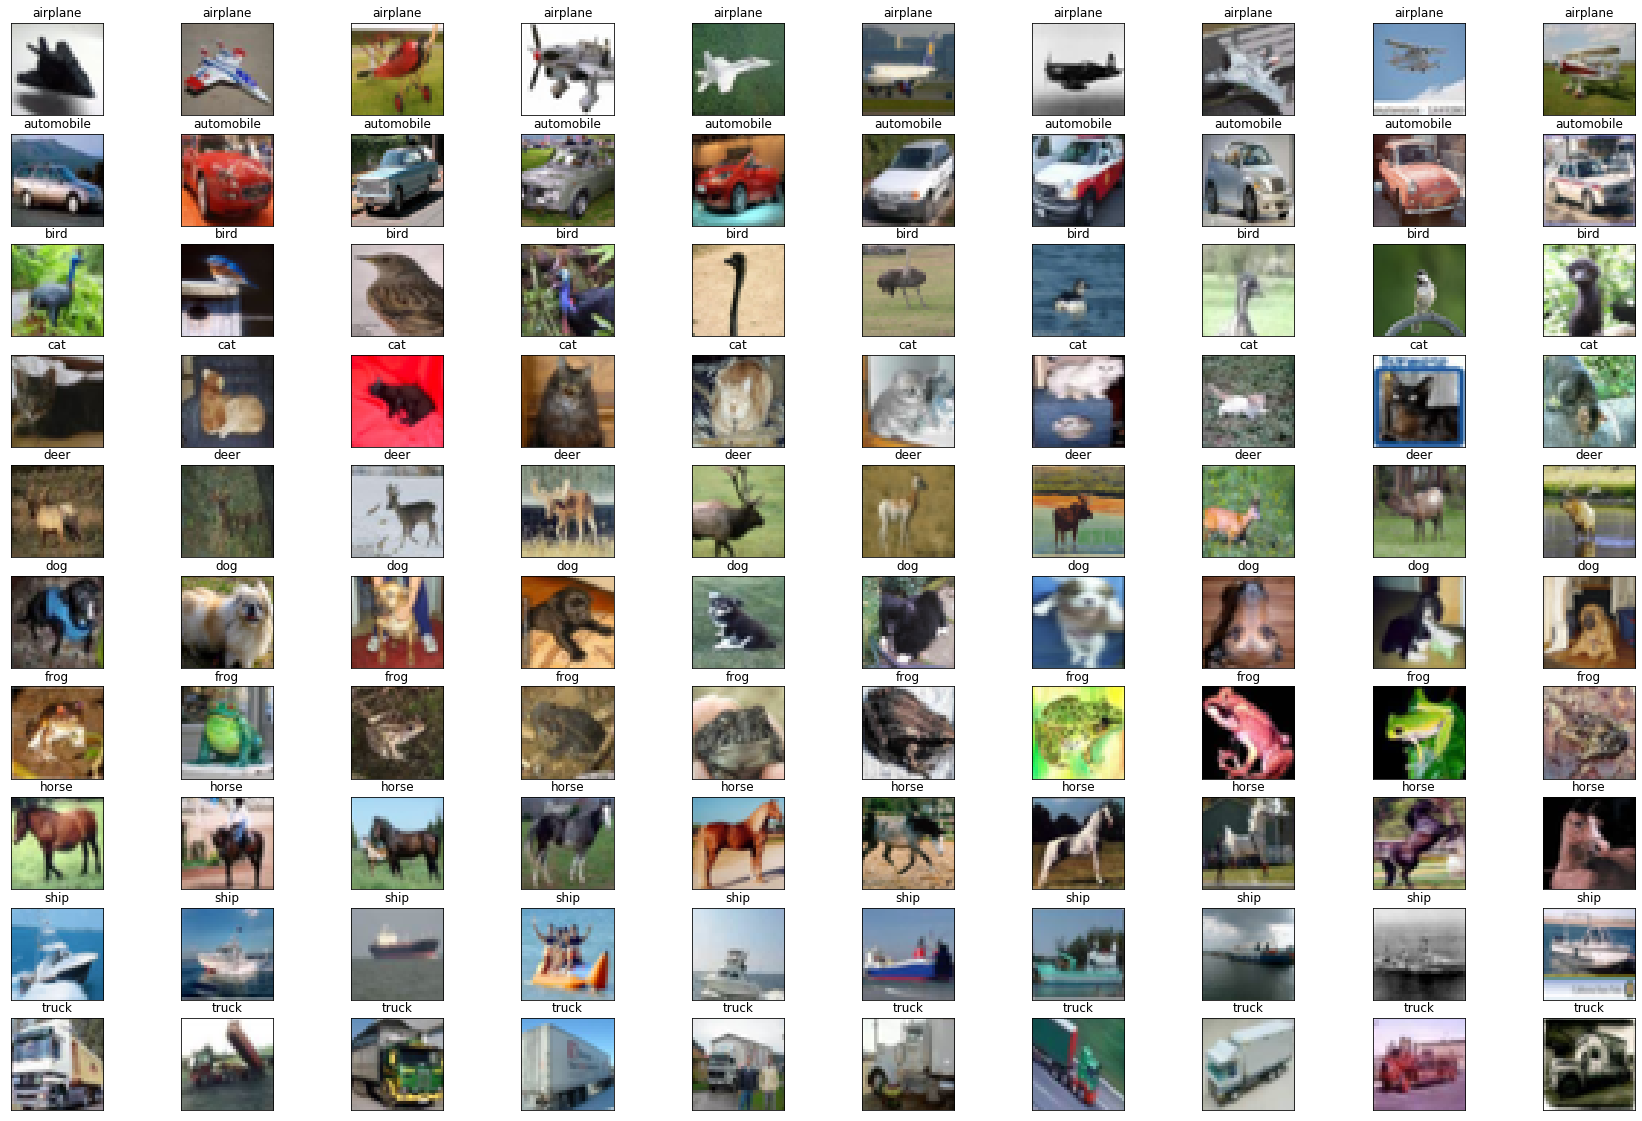

In [13]:
show_images(data_set_showcase_images, data_num_classes, data_set_showcase_labels, downscale=0.05)

# 2. SVM

In [14]:
# converts numpy array from RGB to Greyscale
def rgb_to_gscale(image):
    
    imcopy = copy.deepcopy(image)
    # https://stackoverflow.com/questions/12201577/how-can-i-convert-an-rgb-image-into-grayscale-in-python
    r, g, b = imcopy[:,:,0], imcopy[:,:,1], imcopy[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
    
    # keep image 3D
    imcopy[:, :, 0] = gray
    imcopy[:, :, 1] = gray
    imcopy[:, :, 2] = gray
    
    return imcopy

In [15]:
# The following 2 functions were copied from my Assignment 2 part 3
# which also required to generate HoG features of a list of images

In [16]:
def image_to_Hog_feat(img):
    cell_size = (8, 8)  # h x w in pixels
    block_size = (2, 2)  # h x w in cells
    nbins = 9  # number of orientation bins

    # create HoG Object
    # winSize is the size of the image cropped to multiple of the cell size
    # all arguments should be given in terms of number of pixels
    hog = cv2.HOGDescriptor(_winSize=(img.shape[1] // cell_size[1] * cell_size[1],
                                  img.shape[0] // cell_size[0] * cell_size[0]),
                        _blockSize=(block_size[1] * cell_size[1],
                                    block_size[0] * cell_size[0]),
                        _blockStride=(cell_size[1], cell_size[0]),
                        _cellSize=(cell_size[1], cell_size[0]),
                        _nbins=nbins)

    n_cells = (img.shape[0] // cell_size[0], img.shape[1] // cell_size[1])

    # Compute HoG features
    hog_feats = hog.compute(img) \
               .reshape(n_cells[1] - block_size[1] + 1,
                        n_cells[0] - block_size[0] + 1,
                        block_size[1], block_size[0], nbins) \
               .transpose((1, 0, 3, 2, 4))  # index blocks by rows first
    
    return hog_feats

In [17]:
def images_to_HoG_features(img_list):
    HoG_features = []
    for image in img_list:
        feat = image_to_Hog_feat(image)
        HoG_features.append(feat)
    
    return HoG_features

In [18]:
# remade the function above to work better with HoG
def Cifar_to_HoG_features(datavector):
    HoG_features = []
    for datapoint in datavector:
        image = rgb_to_gscale(datapoint[0])
        feat  = image_to_Hog_feat(image)
        HoG_features.append(feat)
        
    return HoG_features

In [21]:
# extract HoG features from X_train and X_train labels
X_train_hog_features = Cifar_to_HoG_features(X_train)
X_train_labels       = [x[1] for x in X_train]

10000
